In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [8]:
# Load the raw Netflix dataset
df = pd.read_csv('../data/raw/Netflix_Dataset.csv')

print("=" * 60)
print("DATA LOADED FOR PREPROCESSING")
print("=" * 60)
print(f"Initial shape: {df.shape}")
print(f"Initial columns: {list(df.columns)}")

# Create a copy for processing
df_clean = df.copy()

DATA LOADED FOR PREPROCESSING
Initial shape: (7789, 11)
Initial columns: ['Show_Id', 'Category', 'Title', 'Director', 'Cast', 'Country', 'Release_Date', 'Rating', 'Duration', 'Type', 'Description']


In [9]:
print("\nMissing values before cleaning:")
print(df_clean.isnull().sum())


Missing values before cleaning:
Show_Id            0
Category           0
Title              0
Director        2388
Cast             718
Country          507
Release_Date      10
Rating             7
Duration           0
Type               0
Description        0
dtype: int64


In [10]:

# Fill missing values with appropriate defaults
df_clean['Director'] = df_clean['Director'].fillna('Unknown Director')
df_clean['Cast'] = df_clean['Cast'].fillna('No Cast Information')
df_clean['Country'] = df_clean['Country'].fillna('Unknown Country')
df_clean['Release_Date'] = df_clean['Release_Date'].fillna('Unknown Date')
df_clean['Rating'] = df_clean['Rating'].fillna('Not Rated')

print("\nMissing values after cleaning:")
print(df_clean.isnull().sum())
print("✓ All missing values handled")



Missing values after cleaning:
Show_Id         0
Category        0
Title           0
Director        0
Cast            0
Country         0
Release_Date    0
Rating          0
Duration        0
Type            0
Description     0
dtype: int64
✓ All missing values handled


In [16]:
# Feature 1: Content Type (Binary)
df_clean['is_tv_show'] = (df_clean['Category'] == 'TV Show').astype(int)
print("✓ Created 'is_tv_show' feature (0=Movie, 1=TV Show)")

# Feature 2: Release Year Normalization
df_clean['Release_Date_dt'] = pd.to_datetime(df_clean['Release_Date'], errors='coerce')
df_clean['Release_Year'] = df_clean['Release_Date_dt'].dt.year.fillna(df_clean['Release_Date_dt'].dt.year.median())
df_clean['Release_Date_norm'] = (df_clean['Release_Year'] - df_clean['Release_Year'].min()) / (df_clean['Release_Year'].max() - df_clean['Release_Year'].min())
print("✓ Created 'Release_Date_norm' feature (normalized to 0-1)")

# Feature 3: Content Age (years since release)
current_year = 2021  # Dataset is from 2021
df_clean['content_age'] = current_year - df_clean['Release_Year']
df_clean['content_age_norm'] = df_clean['content_age'] / df_clean['content_age'].max()
print("✓ Created 'content_age' and normalized version")

print(f"\nCurrent features shape: {df_clean.shape}")

# Feature Engineering - Rating Encoding
print("\n" + "=" * 60)
print("STEP 3: RATING ENCODING")
print("=" * 60)

# Create rating hierarchy mapping
rating_map = {
    # Kids/Family
    'G': 1, 'TV-Y': 1, 'TV-G': 1,
    # Older Kids
    'PG': 2, 'TV-Y7': 2, 'TV-Y7-FV': 2,
    # Teens
    'PG-13': 3, 'TV-PG': 3,
    # Adults
    'R': 4, 'TV-14': 4,
    # Mature Adults
    'NC-17': 5, 'TV-MA': 5,
    # Not Rated
    'NR': 3, 'UR': 3, 'Not Rated': 3
}

print("Rating hierarchy mapping:")
for rating, level in sorted(rating_map.items(), key=lambda x: x[1]):
    count = (df_clean['Rating'] == rating).sum()
    print(f"  {rating:12} → Level {level}  ({count:4} titles)")

# Apply mapping and normalize
df_clean['rating_level'] = df_clean['Rating'].map(rating_map).fillna(3)
df_clean['rating_level_norm'] = (df_clean['rating_level'] - 1) / 4  # Normalize to 0-1

print("\n✓ Rating encoded and normalized")
print(f"Rating level distribution:\n{df_clean['rating_level'].value_counts().sort_index()}")


✓ Created 'is_tv_show' feature (0=Movie, 1=TV Show)
✓ Created 'Release_Date_norm' feature (normalized to 0-1)
✓ Created 'content_age' and normalized version

Current features shape: (7789, 17)

STEP 3: RATING ENCODING
Rating hierarchy mapping:
  G            → Level 1  (  39 titles)
  TV-Y         → Level 1  ( 280 titles)
  TV-G         → Level 1  ( 194 titles)
  PG           → Level 2  ( 247 titles)
  TV-Y7        → Level 2  ( 271 titles)
  TV-Y7-FV     → Level 2  (   6 titles)
  PG-13        → Level 3  ( 386 titles)
  TV-PG        → Level 3  ( 806 titles)
  NR           → Level 3  (  84 titles)
  UR           → Level 3  (   5 titles)
  Not Rated    → Level 3  (   7 titles)
  R            → Level 4  ( 665 titles)
  TV-14        → Level 4  (1931 titles)
  NC-17        → Level 5  (   3 titles)
  TV-MA        → Level 5  (2865 titles)

✓ Rating encoded and normalized
Rating level distribution:
1     513
2     524
3    1288
4    2596
5    2868
Name: rating_level, dtype: int64


In [22]:
# Extract all genres
all_genres = df_clean['Type'].dropna().str.split(',').explode().str.strip()
genre_counts = all_genres.value_counts()

print(f"Total unique genres: {len(genre_counts)}")
print("\nTop 10 genres:")
print(genre_counts.head(10))

# Select top N genres for features
top_n = 10
top_genres = genre_counts.head(top_n).index.tolist()

print(f"\nCreating binary features for top {top_n} genres...")

# Create binary features for each top genre
for genre in top_genres:
    # Create clean column name
    col_name = f"genre_{genre.lower().replace(' ', '_').replace('&', 'and').replace('-', '_')}"
    df_clean[col_name] = df_clean['Type'].fillna('').str.contains(genre, case=False).astype(int)
    count = df_clean[col_name].sum()
    print(f"  ✓ {col_name:40} ({count:4} titles)")

print(f"\n✓ Created {top_n} genre features")

# Cell 7: Feature Engineering - Duration Features
print("\n" + "=" * 60)
print("STEP 5: DURATION FEATURE EXTRACTION")
print("=" * 60)

# Extract numeric duration
def extract_duration(duration_str):
    """Extract numeric value from duration string"""
    if pd.isna(duration_str) or duration_str == 'Unknown Duration':
        return np.nan
    numbers = [int(s) for s in str(duration_str).split() if s.isdigit()]
    return numbers[0] if numbers else np.nan

df_clean['duration_numeric'] = df_clean['Duration'].apply(extract_duration)

# Separate handling for movies (minutes) and TV shows (seasons)
movies_mask = df_clean['Category'] == 'Movie'
tv_mask = df_clean['Category'] == 'TV Show'

# For movies: normalize minutes
if movies_mask.any():
    movie_durations = df_clean.loc[movies_mask, 'duration_numeric']
    movie_durations_filled = movie_durations.fillna(movie_durations.median())
    df_clean.loc[movies_mask, 'duration_norm'] = (
        (movie_durations_filled - movie_durations_filled.min()) / 
        (movie_durations_filled.max() - movie_durations_filled.min())
    )
    print(f"✓ Movie duration normalized (range: {movie_durations.min():.0f} - {movie_durations.max():.0f} minutes)")

# For TV shows: normalize seasons
if tv_mask.any():
    tv_durations = df_clean.loc[tv_mask, 'duration_numeric']
    tv_durations_filled = tv_durations.fillna(tv_durations.median())
    df_clean.loc[tv_mask, 'duration_norm'] = (
        (tv_durations_filled - tv_durations_filled.min()) / 
        (tv_durations_filled.max() - tv_durations_filled.min())
    )
    print(f"✓ TV show seasons normalized (range: {tv_durations.min():.0f} - {tv_durations.max():.0f} seasons)")

# Fill any remaining NaN in duration_norm
df_clean['duration_norm'] = df_clean['duration_norm'].fillna(0.5)

Total unique genres: 42

Top 10 genres:
International Movies        2437
Dramas                      2108
Comedies                    1472
International TV Shows      1199
Documentaries                786
Action & Adventure           721
TV Dramas                    704
Independent Movies           675
Children & Family Movies     532
Romantic Movies              531
Name: Type, dtype: int64

Creating binary features for top 10 genres...
  ✓ genre_international_movies               (2437 titles)
  ✓ genre_dramas                             (2812 titles)
  ✓ genre_comedies                           (1997 titles)
  ✓ genre_international_tv_shows             (1199 titles)
  ✓ genre_documentaries                      ( 786 titles)
  ✓ genre_action_and_adventure               ( 871 titles)
  ✓ genre_tv_dramas                          ( 704 titles)
  ✓ genre_independent_movies                 ( 675 titles)
  ✓ genre_children_and_family_movies         ( 532 titles)
  ✓ genre_romantic_movies  

In [25]:
# Extract all countries
all_countries = df_clean['Country'].dropna().str.split(',').explode().str.strip()
country_counts = all_countries.value_counts()

# Top producing countries
top_countries = country_counts.head(5).index.tolist()

print("Creating binary features for top 5 countries...")
for country in top_countries:
    col_name = f"country_{country.lower().replace(' ', '_')}"
    df_clean[col_name] = df_clean['Country'].fillna('').str.contains(country, case=False).astype(int)
    count = df_clean[col_name].sum()
    print(f"  ✓ {col_name:30} ({count:4} titles)")

print("✓ Created country features")

# Cell 9: Prepare Clustering Features
print("\n" + "=" * 60)
print("STEP 7: PREPARING FINAL FEATURE SET")
print("=" * 60)

# Collect all feature columns
feature_columns = [
    'is_tv_show',
    'Release_Date_norm',
    'rating_level_norm',
    'duration_norm'
]

# Add genre features
genre_features = [col for col in df_clean.columns if col.startswith('genre_')]
feature_columns.extend(genre_features)


print(f"\nSelected {len(feature_columns)} features for clustering:")
for i, feature in enumerate(feature_columns, 1):
    print(f"  {i:2}. {feature}")

# Create feature matrix
features_df = df_clean[feature_columns].copy()

# Handle any remaining NaN values
features_df = features_df.fillna(0)

print(f"\n✓ Feature matrix shape: {features_df.shape}")
print(f"✓ No missing values: {features_df.isnull().sum().sum() == 0}")

Creating binary features for top 5 countries...
  ✓ country_united_states          (3298 titles)
  ✓ country_india                  ( 990 titles)
  ✓ country_united_kingdom         ( 723 titles)
  ✓ country_unknown_country        ( 507 titles)
  ✓ country_canada                 ( 412 titles)
✓ Created country features

STEP 7: PREPARING FINAL FEATURE SET

Selected 14 features for clustering:
   1. is_tv_show
   2. Release_Date_norm
   3. rating_level_norm
   4. duration_norm
   5. genre_international_movies
   6. genre_dramas
   7. genre_comedies
   8. genre_international_tv_shows
   9. genre_documentaries
  10. genre_action_and_adventure
  11. genre_tv_dramas
  12. genre_independent_movies
  13. genre_children_and_family_movies
  14. genre_romantic_movies

✓ Feature matrix shape: (7789, 14)
✓ No missing values: True


Feature value ranges:
     is_tv_show  Release_Date_norm  rating_level_norm  duration_norm  \
min         0.0                0.0                0.0            0.0   
max         1.0                1.0                1.0            1.0   

     genre_international_movies  genre_dramas  genre_comedies  \
min                         0.0           0.0             0.0   
max                         1.0           1.0             1.0   

     genre_international_tv_shows  genre_documentaries  \
min                           0.0                  0.0   
max                           1.0                  1.0   

     genre_action_and_adventure  genre_tv_dramas  genre_independent_movies  \
min                         0.0              0.0                       0.0   
max                         1.0              1.0                       1.0   

     genre_children_and_family_movies  genre_romantic_movies  
min                               0.0                    0.0  
max                          

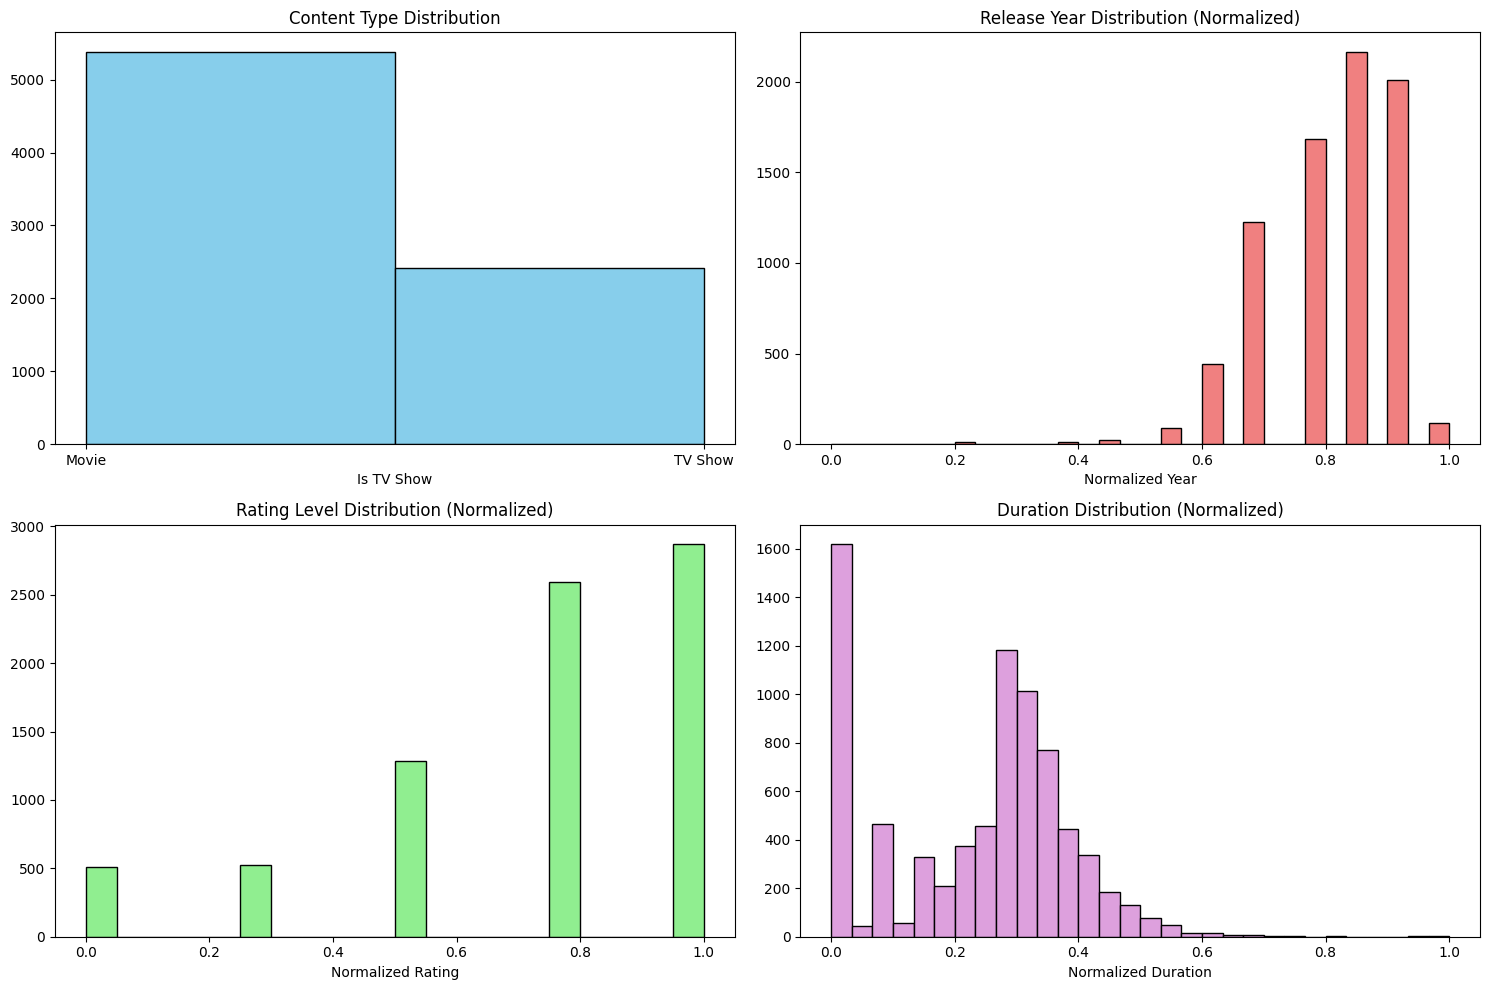

In [26]:
print("Feature value ranges:")
print(features_df.describe().loc[['min', 'max']])

# Visualize feature distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Basic features
axes[0, 0].hist(features_df['is_tv_show'], bins=2, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Content Type Distribution')
axes[0, 0].set_xlabel('Is TV Show')
axes[0, 0].set_xticks([0, 1])
axes[0, 0].set_xticklabels(['Movie', 'TV Show'])

axes[0, 1].hist(features_df['Release_Date_norm'], bins=30, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Release Year Distribution (Normalized)')
axes[0, 1].set_xlabel('Normalized Year')

axes[1, 0].hist(features_df['rating_level_norm'], bins=20, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Rating Level Distribution (Normalized)')
axes[1, 0].set_xlabel('Normalized Rating')

axes[1, 1].hist(features_df['duration_norm'], bins=30, color='plum', edgecolor='black')
axes[1, 1].set_title('Duration Distribution (Normalized)')
axes[1, 1].set_xlabel('Normalized Duration')

plt.tight_layout()
plt.show()


Genre feature correlation:


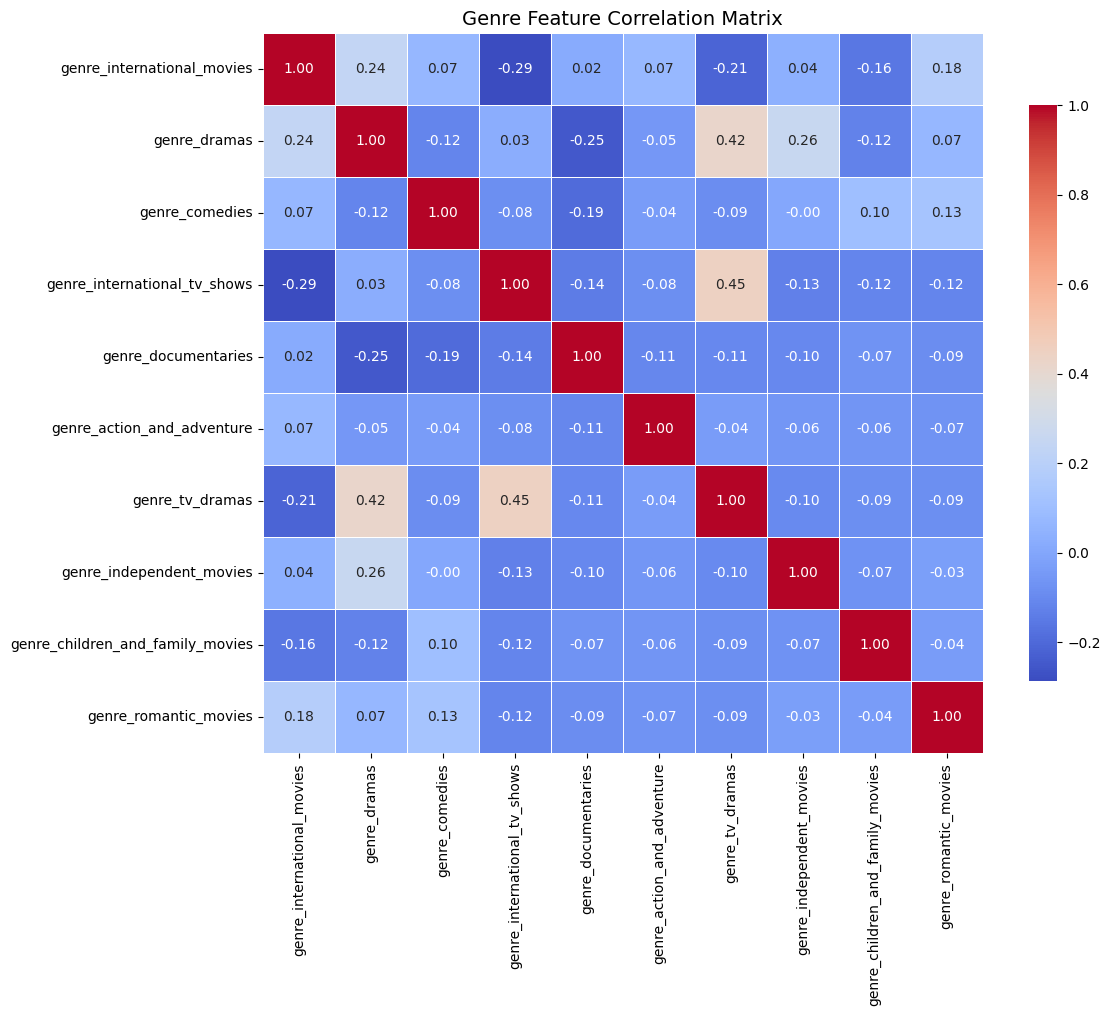

✓ Genre correlations visualized


In [27]:
print("\nGenre feature correlation:")

# Select genre features for heatmap
genre_cols = [col for col in features_df.columns if col.startswith('genre_')]
if len(genre_cols) > 0:
    genre_data = features_df[genre_cols]
    
    # Calculate correlation
    genre_corr = genre_data.corr()
    
    # Visualize
    plt.figure(figsize=(12, 10))
    sns.heatmap(genre_corr, annot=True, fmt='.2f', cmap='coolwarm', 
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
    plt.title('Genre Feature Correlation Matrix', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print("✓ Genre correlations visualized")

In [28]:
# Save cleaned full dataset
output_path_full = '../data/processed/netflix_processed.csv'
df_clean.to_csv(output_path_full, index=False)
print(f"✓ Saved full processed dataset: {output_path_full}")
print(f"  Shape: {df_clean.shape}")

# Save feature matrix for clustering
output_path_features = '../data/processed/clustering_features.csv'
features_df.to_csv(output_path_features, index=False)
print(f"✓ Saved clustering features: {output_path_features}")
print(f"  Shape: {features_df.shape}")

# Save feature names for later reference
feature_info = pd.DataFrame({
    'feature_name': feature_columns,
    'feature_type': ['basic' if col in ['is_tv_show', 'Release_Date_norm', 'rating_level_norm', 'duration_norm'] 
                     else 'genre' for col in feature_columns]
})
output_path_info = '../data/processed/feature_info.csv'
feature_info.to_csv(output_path_info, index=False)
print(f"✓ Saved feature information: {output_path_info}")

✓ Saved full processed dataset: ../data/processed/netflix_processed.csv
  Shape: (7789, 36)
✓ Saved clustering features: ../data/processed/clustering_features.csv
  Shape: (7789, 14)
✓ Saved feature information: ../data/processed/feature_info.csv
